<a href="https://colab.research.google.com/github/ella00100/Kaggle_competition/blob/main/Porto%2002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c porto-seguro-safe-driver-prediction
!ls

Saving kaggle.json to kaggle.json
 95% 73.0M/76.5M [00:02<00:00, 35.0MB/s]
100% 76.5M/76.5M [00:02<00:00, 26.9MB/s]
kaggle.json  porto-seguro-safe-driver-prediction.zip  sample_data


In [4]:
!unzip porto-seguro-safe-driver-prediction.zip

Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
#trian 데이터 확인
rows = train.shape[0]
columns = train.shape[1]
print(f"The train dataset contains {rows} rows and {columns} columns")

The train dataset contains 595212 rows and 59 columns


# Data Quality checks
null or missing values check



In [7]:
#null 데이터 확인
train.isnull().any().any()

False

null 데이터는 없다고 나왔지만, 실제로는 null 데이터가 -1로 표시되어있습니다. 


In [8]:
#train데이터를 복제해서 -1을 null로 변경
train_copy = train
train_copy = train_copy.replace(-1, np.NAN)

<Axes: >

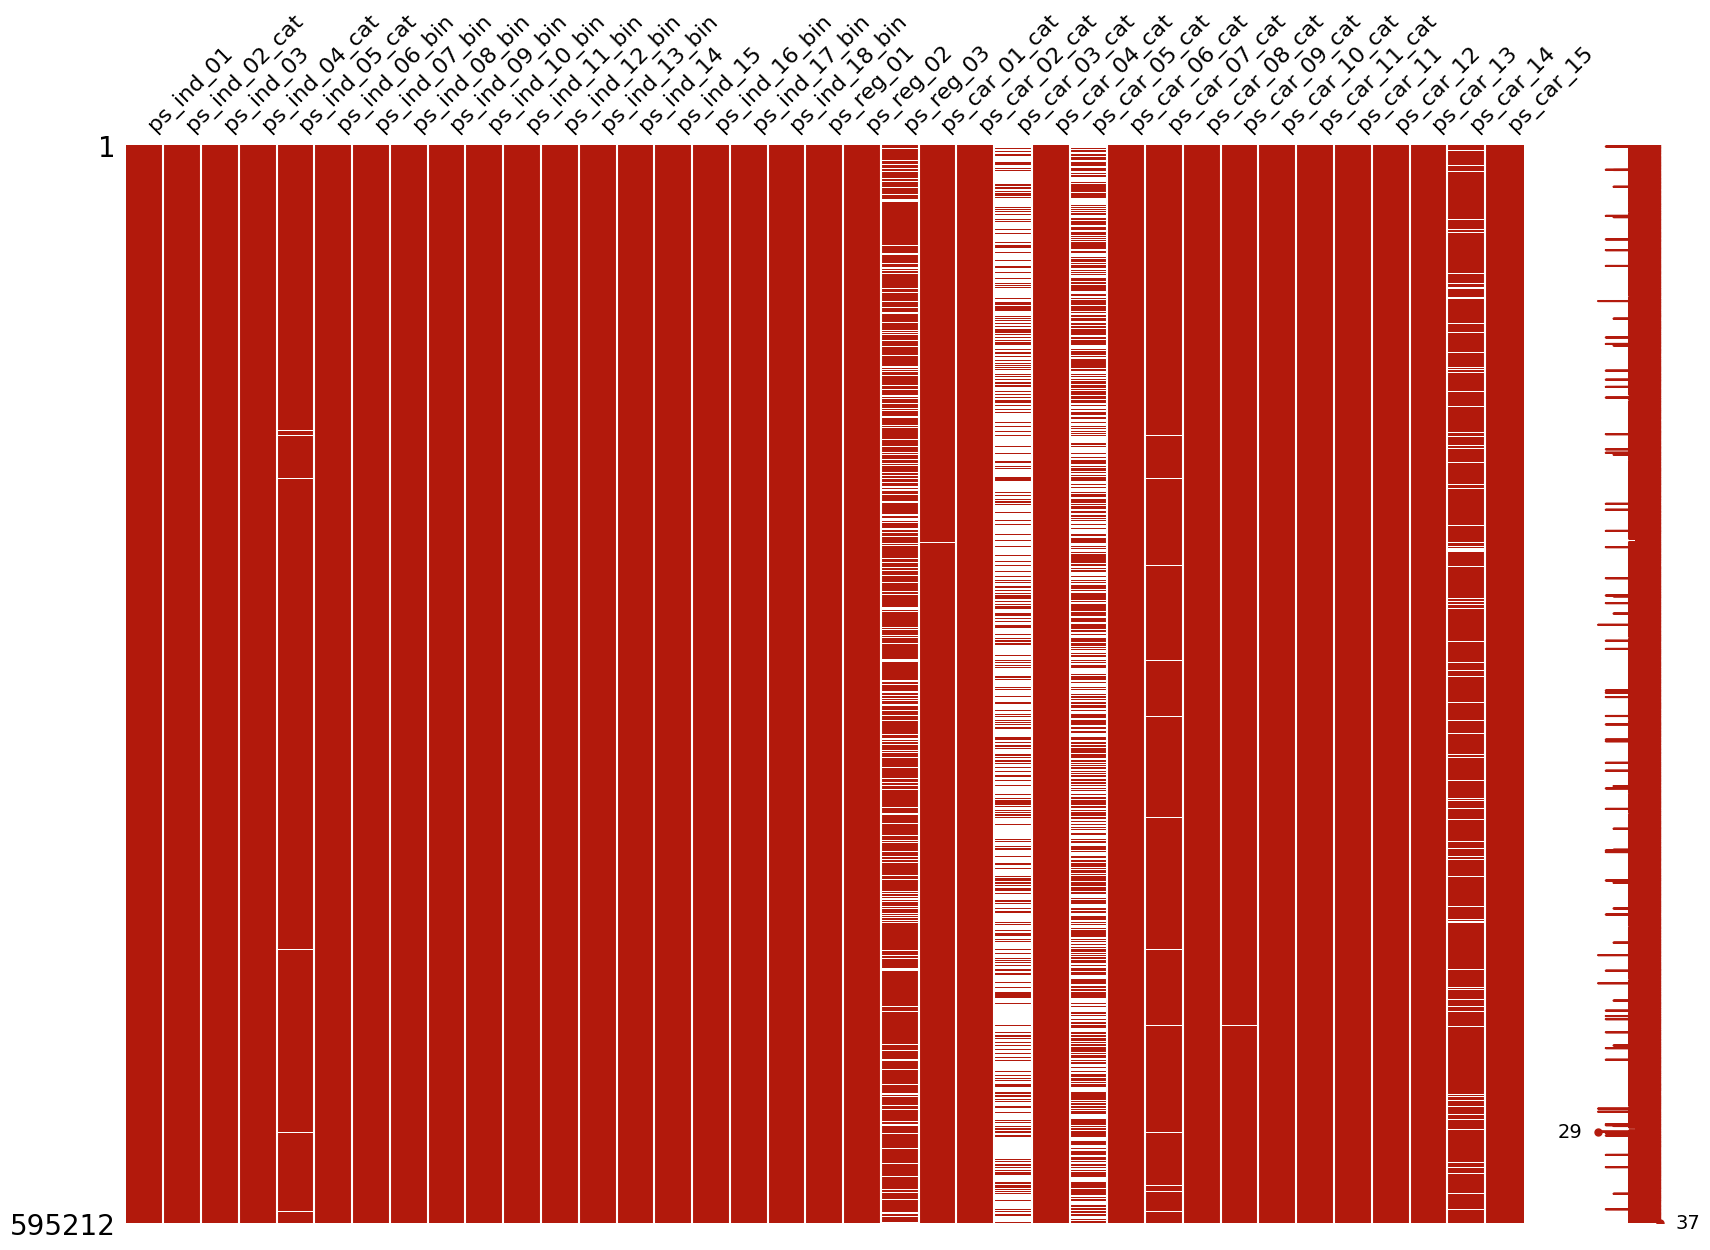

In [9]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20,14), color=(0.7, 0.1, 0.05))

- 하얀색 부분이 결측치를 나타냅니다, 

- 총 59개의 feature 중 7개의 feature에 null값이 존재하는 것을 확인할 수 있습니다. (그러나 실제 unll 값이 포함된 열은 13개입니다)

- ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14

- 특히 _cat으로 끝나는 열이 결측치가 많이 포함되어 있는 것으로 보입니다. 

## Target variable inspection



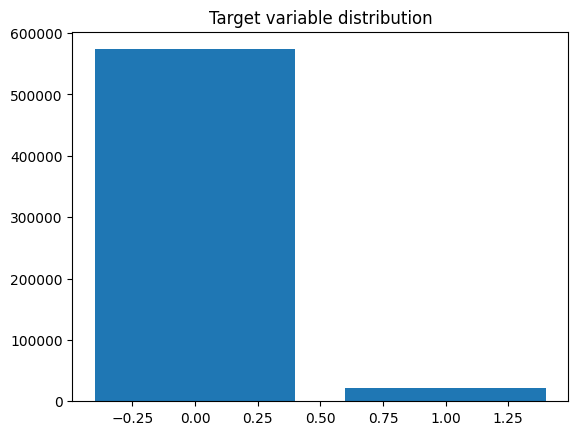

In [10]:
#plt 라이브러리 이용
target_counts = train["target"].value_counts()

plt.bar(target_counts.index.values, target_counts.values)
plt.title('Target variable distribution')
plt.show()

- 현재 타겟 변수가 꽤 불균형한 것으로 보입니다. 

## Datatype check

- 학습 세트가 어떤 종류의 데이터 타입으로 구성되어 있는지를 확인합니다. 



In [11]:
#train 데이터의 colume에 대한 데이터 타입 파악
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

- train 데이터 셋을 총 59개의 열로 구성되어 있으며 int64형 49개, fliat64형이 10개 입니다. 

- 또한 칼럼에서 _bin, _cat, _reg 와같은 접미사는 데이터 타입에 대한 정보를 제공합니다. 

In [12]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

# Correlation plots

- feature간의 선형 상관관계를 확인합니다. 


## Correlation of float features

<Axes: title={'center': 'Pearson correlation of continuous features'}>

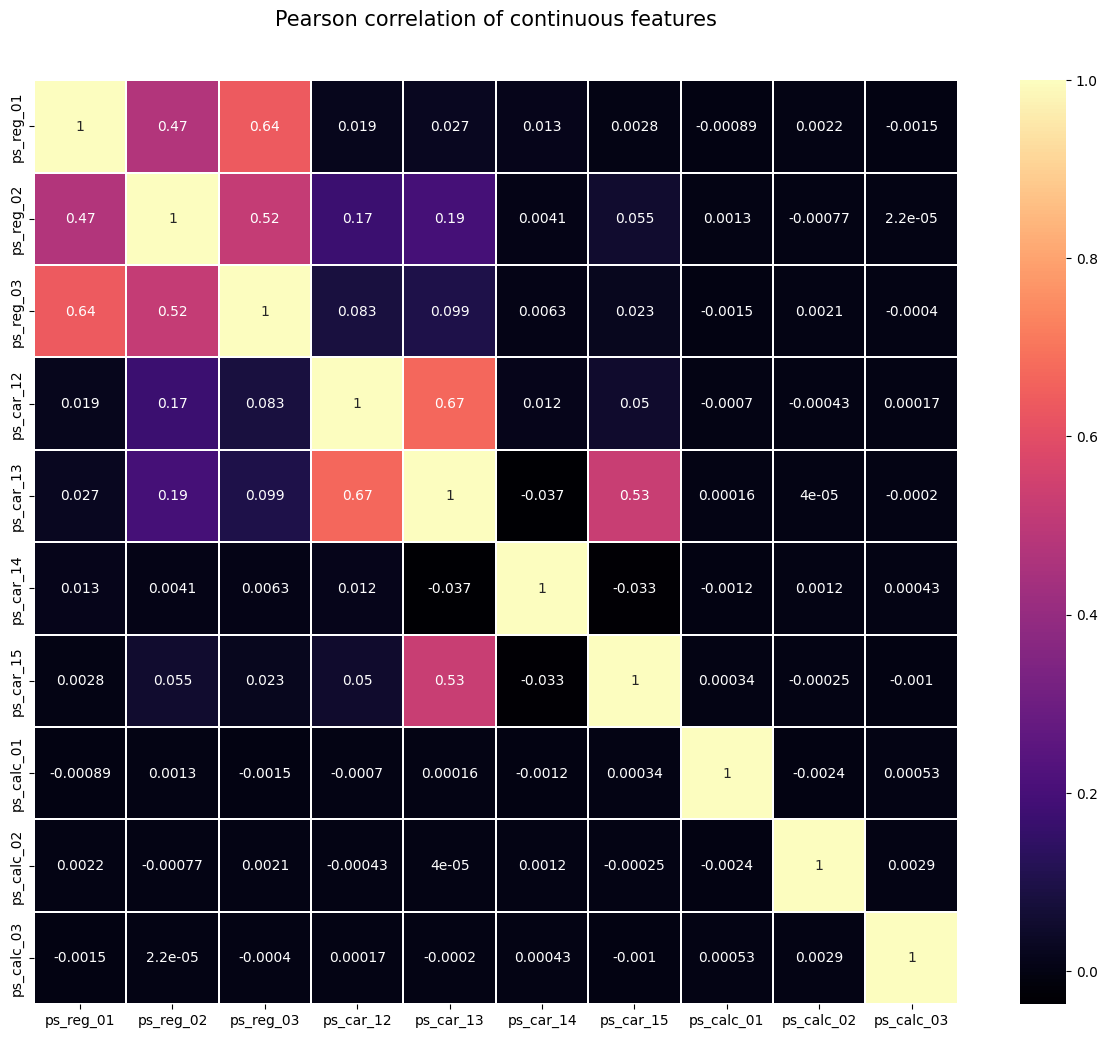

In [13]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

양의 선형 상관 관계가 나타나는 특성 쌍
- (ps_reg_01, ps_reg_03) : 0.64

- (ps_reg_02, ps_reg_03) : 0.52

- (ps_car_12, ps_car_13) : 0.67

- (ps_car_13, ps_car_15) : 0.53

##Correlation of integer features


- 정수 데이터 타입 열에 대해서는, 상호 작용적으로 상관 관계 값을 표시하는 히트맵을 생성하는 방법으로 Plotly 라이브러리를 사용하는 것이 좋습니다. 

- 이전에 사용한 Plotly 플롯과 마찬가지로, "go.Heatmap"을 호출하여 히트맵 객체를 생성합니다. 

- 여기서는 x축과 y축이 열 이름을 취하고 상관 관계 값은 z-축으로 제공해야 합니다. 색상 척도 속성은 히트맵에서 볼 수 있는 다른 색상 팔레트에 해당하는 키워드를 취하며, 이 예제에서는 Greys 색상 척도를 사용했습니다 (Portland와 Viridis도 시도해보세요).

In [15]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.renderers.default = 'colab'


In [18]:
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

- 비슷하게, 우리는 상관 관계 플롯에서 많은 0 값 셀들을 볼 수 있으며, 서로 선형적으로 상관관계가 없는 열이 많다는 것을 알 수 있습니다. 

- 이는 차원 축소 변환 (예: 주성분 분석 (PCA))을 수행하려는 경우에 매우 유용한 관찰입니다. 이는 일정 수준의 상관관계가 필요하기 때문입니다. 우리는 다음과 같은 관심 있는 특징들을 알아낼 수 있습니다:

- 음의 상관관계를 가진 특징 : 
  - ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

- 또 하나 흥미로운 점은 이전에 결측값(null)에 대한 분석에서 ps_car_03_cat과 ps_car_05_cat이 많은 결측값을 포함한다는 것입니다. 

- 따라서 이러한 특징들은 서로 상당히 강한 양의 선형 상관관계가 있는 것으로 나타납니다. 그러나 이는 실제 데이터에 대한 진실을 정확하게 반영하지는 않을 수 있습니다.


#Mutual Information plots

- Multual Information은 타겟 변수와 해당 feature 간의 상호 정보량을 조사할 수 있는 또 다른 유용한 도구입니다. 

- 분류 문제의 경우 Sklearn의 mutual_info_classif 메소드를 편리하게 호출할 수 있습니다. 이는 두 개의 무작위 변수 간의 종속성을 측정하며, 0 (두 변수가 서로 독립적인 경우)에서 높은 값(일부 종속성을 나타내는 값)까지 범위가 있습니다. 이는 따라서 우리에게 타겟에서 얼마나 많은 정보가 feature에 포함되어 있는지에 대한 아이디어를 제공합니다.

- mutual_info_classif 함수의 Sklearn 구현은 "k-nearest neighbors distances를 기반으로 엔트로피 추정에 기초한 비모수 방법을 사용한다"고 말합니다. 이에 대한 더 자세한 내용은 여기에서 공식 Sklearn 페이지를 참조할 수 있습니다.

In [19]:
# float feature와 target 간의 mutual information(상호정보량)을 계산
mf = mutual_info_classif(
    train_float.values, 
    train.target.values, 
    n_neighbors=3, #k-nearest neighbor 수
    random_state=17) #랜덤 시드값
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


#Binary features inspection

- 데이터의 다른 측면으로 살펴볼 수 있는 것은 1 또는 0 중 하나의 값만 가지는 이진 값(binary values)을 포함하는 열입니다. 따라서 이진 값만 포함하는 모든 열을 저장한 후 다음과 같이 이진 값들의 수직 Plotly 막대 그래프를 생성합니다

In [20]:
#binary columns의 값 분포 조사
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
  zero_list.append((train[col]==0).sum())
  one_list.append((train[col]==1).sum())

In [21]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list,
    name='Zero count'
)

trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]

layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

- 여기에서는 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 등 4가지 특징이 0으로 완전히 지배된다는 것을 알 수 있습니다. 이러한 특징은 대상(target)과 관련된 정보가 거의 없기 때문에 유용한지 여부에 대한 의문을 제기합니다.

# Categofical and Oridinal feature inspection
먼저 접미사 "_cat"에 따라 범주형으로 지정된 특징들을 살펴보겠습니다.


#Feature importance via Random Forest

- 이제 Random Forest 분류기(Random Forest Classifier)를 사용하여 훈련 데이터를 적합하고 모델 훈련이 완료된 후 특징 순위를 살펴보겠습니다. 

- 이는 유용한 특징 중요도를 얻기 위한 매우 빠른 방법으로 (부트스트랩 집계 밑에 약한 의사 결정 트리 학습기의 앙상블 모델) 매개 변수 튜닝이 거의 필요하지 않으며 대상(target) 불균형에 대해서도 꽤 견고합니다. Random Forest를 다음과 같이 호출합니다.

In [22]:
#랜덤 포레스트 분류기 모델 정의 & 학습
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4,
                            max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


### Plotly Scatter Plot of feature importances

- Random Forest 모델을 학습한 후, "feature_importances" 속성을 호출하여 feature importance 리스트를 얻을 수 있습니다. 이를 이용하여 다음 Plotly plot, 산점도(Scatter plot)를 그릴 수 있습니다.

- 여기에서는 Scatter 명령어를 호출하고 이전 Plotly plot과 같이 y축과 x축을 정의해야 합니다. 그러나 Scatter plot에서 주의해야 할 점은 marker attribute입니다. marker attribute에서 scatter point의 크기, 색상 및 스케일을 정의하고 제어합니다.

In [25]:
#feature 이름과 중요도의 scatter plot
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref =1,
        size=13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

- 또한 우리는 다음과 같은 plotly 막대 그래프를 통해 중요도에 따라 모든 피쳐의 정렬된 목록을 표시할 수도 있습니다.

In [27]:
# Porto Seguro 데이터셋에서 학습한 모델에서 각 feature의 중요도를 시각화
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x, y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale= True
    ),
    name = 'Random Forest Feature importance',
    orientation='h'
)

layout  = dict(
    title = 'Barplot of Feature importances',
    width = 900, height= 2000,
    yaxis = dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

###Decision Tree visualisation

- 모델에서 만든 트리 분기나 결정을 시각화하는 것은 흥미로운 기술 중 하나입니다. 간단히 말해서, 최대 깊이가 3인 의사결정나무 모델을 적합하고, sklearn의 "export_graphviz"를 사용하여 시각화를 위해 트리 이미지를 내보내고 이 노트북에서 시각화하기 위해 이미지를 가져왔습니다.

In [28]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re


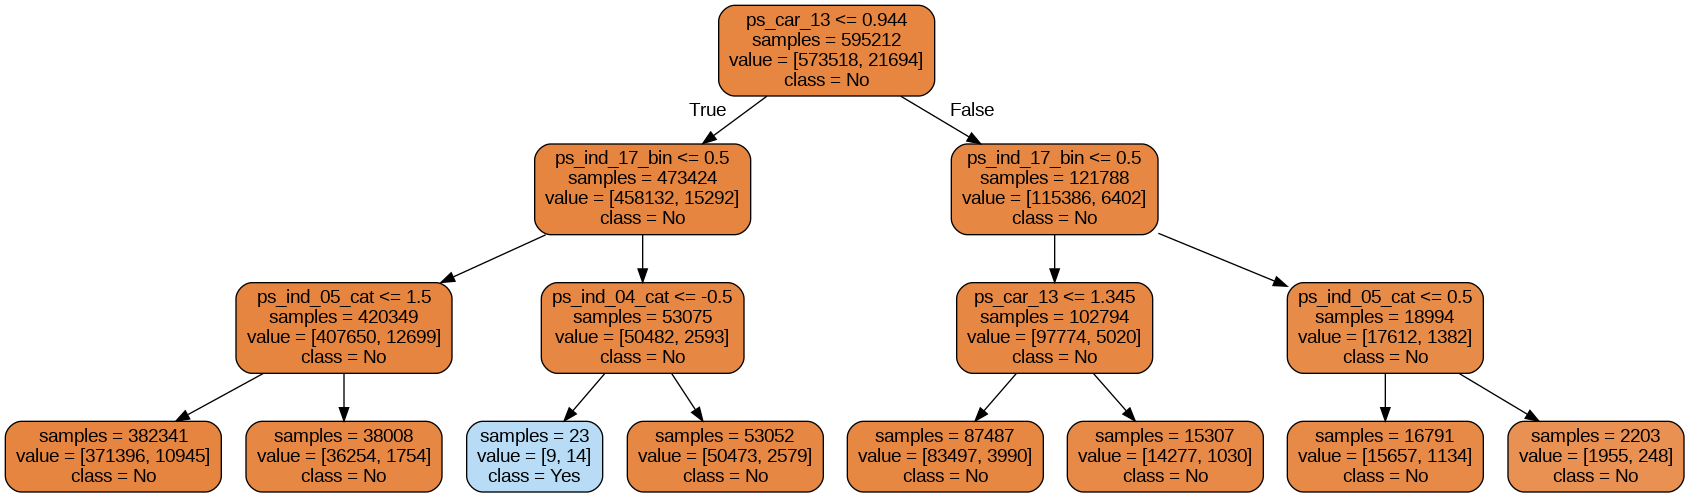

In [29]:
#결정 트리 모델을 학습하고, 학습된 결정 트리 모델을 시각화

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )

check_call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png'])

img = Image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png')

#Feature Importace via Gradient Boosting model

- 그라디언트 부스팅 모델을 사용하여 피쳐 중요도를 구해보는 것도 흥미로울 것입니다. 

- 이번에는 Gradient Boosting 분류기를 사용하여 학습 데이터에 맞추어 봅시다. Gradient Boosting은 각 단계에서 손실 함수의 기울기에 대한 회귀 트리를 적합시키는 순방향 단계별 접근법을 취합니다 (Sklearn 구현에서 기본값으로 deviance를 사용합니다).

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values

print("----- Training Done ------")

----- Training Done ------


In [34]:
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = gb.feature_importances_,
        colorscale = 'Portland',
        showscale=True
    ),
    text = features
)

data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [36]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))

trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale='Viridis',
        reversescale = True
    ),
    name = 'Gradient Boosting Classifer Feature importance',
    orientation = 'h'
)

layout = dict(
    title = 'Barplot of Feature importances',
    width = 900, height = 2000,
    yaxis = dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

놀랍게도 랜덤 포레스트와 그래디언트 부스팅 모델에서 모두 가장 중요한 특성으로 선정된 열인 ps_car_13을 관찰할 수 있습니다.

이 특성은 추가적인 조사가 필요하므로 이에 대해 자세히 살펴보겠습니다.

#Conclusion

우리는 널 값과 데이터 품질을 검사하고, 특성들 간의 선형 상관 관계를 조사하며, 몇 가지 특성 분포를 조사하고, 중요한 특성을 식별하기 위해 두 개의 학습 모델(Random Forest와 Gradient Boosting Classifier)을 구현함으로써 Porto Seguro 데이터셋을 광범위하게 검사했습니다. 또한, 이 중요한 특성에 대해 깊이 들어가보기로 했습니다.